### Semantic Segmentation DataSet method with incremental build (avoid full rebuild)
This method builds and archives the necessary data for Semantic Segmentation: images and masks

In [2]:
import shutil, glob, json, os, time
import numpy as np
from PIL import Image, ImageDraw
import rasterio
import matplotlib
import hashlib
import tarfile

def to_mask_file_name(file_name):
    file_name = os.path.basename(file_name)
    name, ext = os.path.splitext(file_name)
    return name + '_mask' + ext

def build_modified_file_map(file_cache_json, folder):
    for path in glob.glob(folder + os.sep + '*'):
        file_cache_json[path] = os.path.getatime(path)

def rebuild_cache(file_cache_json, folder, mod_new_set):
    file_cache_json = {}

    for path in glob.glob(folder + os.sep + '*'):
        file_cache_json[path] = os.path.getatime(path)
        if path in file_cache_json:
            if file_cache_json[path] != os.path.getatime(path):
                print('modified: {}'.format(path))
                mod_new_set.add(path)
        else:
            mod_new_set.add(path)
            print('new: {}'.format(path))

    return file_cache_json

def get_rebuild_mask_set(image_list, masks_dir, mod_new_set):
    for path in image_list:
        if not os.path.exists(masks_dir + os.sep + to_mask_file_name(path)):
            mod_new_set.add(path)

def build_merged_labels(label_files):
    labels_merged = {}

    for label_file in label_files:
        label_json = json.load(open(label_file))
        for key in label_json.keys():
            if key not in labels_merged:
                labels_merged[key] = label_json[key]

    return labels_merged

def get_mask_shape_xy(regions):
    X = []; Y = []

    for k in regions:
        X.append(regions[k]['shape_attributes']['all_points_x'])
        Y.append(regions[k]['shape_attributes']['all_points_y'])

    return Y, X

def create_water_mask_np(reg_x, reg_y, image):
    nx, ny, nz = np.shape(image)
    mask = np.zeros((ny,nx))

    for x, y in zip(reg_x, reg_y):
        polygon = np.vstack((x, y)).reshape((-1,), order='F').tolist()
        img = Image.new('1', (nx, ny), 0)
        ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
        m = np.array(img)
        mask = mask + m

    return mask

def create_water_mask_image(image_path, labels, mask_dir):
    if not 'regions' in labels:
        print('no regions for: {}'.format(image_path))
        return ""

    mask_file = mask_dir + os.sep + to_mask_file_name(image_path)
    print('creating mask image: {}'.format(mask_file))

    # Get reagions mask
    reg_y, reg_x = get_mask_shape_xy(labels['regions'])

    # Open image & draw regions & save mask image
    with rasterio.open(image_path) as dataset:
        image = dataset.read().T
        mask = create_water_mask_np(reg_x, reg_y, image)
        # matplotlib.image.imsave(mask_file, mask.astype('uint8'), cmap='gray')
        matplotlib.image.imsave(mask_file, mask.astype('uint8'))
        print('done')

    return mask_file

def generate_sha256(file):
    sha256_hash = hashlib.sha256()
    with open(file,"rb") as f:
        for byte_block in iter(lambda: f.read(4096), b""):
            sha256_hash.update(byte_block)

    return sha256_hash.hexdigest()

def build_dataset(img_dir, labels_dir, out_archive_name='train_dataset', force=False, repackage=False):
    print('input dirs: images: {}, labels: {}'.format(img_dir, labels_dir))

    img_mask_dir = img_dir + '_mask'
    if not os.path.exists(img_mask_dir):
        os.mkdir(img_mask_dir);

    # rebuild image set
    rebuild_set = set()

    # Load cache
    cache_file = '.cache'
    cache = {}

    # Prevent load cache file if we want to rebuild the entire dataset
    if not force and os.path.exists(cache_file):
        cache = json.load(open(cache_file))

    # build list of modified files
    key_dir = {
        "labels" : labels_dir,
        "images" : img_dir,
        "images_mask" : img_mask_dir
    }

    for key, folder in key_dir.items():
        if not key in cache:
            cache[key] = {}

        cache[key] = rebuild_cache(cache[key], folder, rebuild_set)

    # Add all images from labels
    for label_file in cache['labels'].keys():
        if not label_file in rebuild_set:
            continue
        label_json = json.load(open(label_file))
        for key in label_json.keys():
            print('regions file changed => rebuild: {}'.format(key))
            rebuild_set.add(img_dir + os.sep + key)

    # Add file for which the masks are not created
    get_rebuild_mask_set(cache['images'].keys(), img_mask_dir, rebuild_set)

    # Build merged labels of regions set
    labels = build_merged_labels(cache['labels'].keys())

    mod_count = 0
    # Rebuild masks
    for path in rebuild_set:
        img_file = os.path.basename(path)
        if img_file in labels:
            mask_file = create_water_mask_image(path, labels[img_file], img_mask_dir)
            if mask_file:
                cache[mask_file] = os.path.getatime(mask_file)
                mod_count+=1
        # Save cache after each mask
        with open(cache_file, 'w') as out_json_file:
            json.dump(cache, out_json_file)

    archive = out_archive_name + ".tar.gz"

    if mod_count == 0:
        print('no changes, the dataset is up to date')
    else:
        print('dataset modified images: {}'.format(mod_count))

    print('output dataset: {}'.format(archive))

    if not force and not repackage and mod_count == 0 and os.path.exists(archive) and archive in cache \
        and cache[archive] == generate_sha256(archive):
            return

    print('creating dataset achive: {}'.format(archive))

    dataset_images = 0
    with tarfile.open(archive, mode='w:gz') as tar:
        for path in cache['images']:
            if not os.path.exists(path):
                continue

            mask_file = to_mask_file_name(path)
            mask_file_path = img_mask_dir + os.sep + mask_file

            if not os.path.exists(mask_file_path):
                continue

            # print('add to archive {} -> {}:/data/{}'.format(file, archive, file))
            tar.add(path, 'images/' + os.path.basename(path))
            tar.add(mask_file_path, 'masks/' + mask_file)
            dataset_images += 1

    cache[archive] = generate_sha256(archive)
    with open(cache_file, 'w') as out_json_file:
        json.dump(cache, out_json_file)

    print('dataset created with {} images :{}'.format(dataset_images, archive))

def extract_dataset_archive(archive_file, output_dir):
    with tarfile.open(archive_file, mode = 'r:gz') as tar:
        tar.extractall(output_dir)

build_dataset('s2cloudless_imagery' + os.sep + 'data', 's2cloudless_labels')

input dirs: images: s2cloudless_imagery/data, labels: s2cloudless_labels
no changes, the dataset is up to date
output dataset: train_dataset.tar.gz


In [5]:
build_dataset('s2cloudless_imagery' + os.sep + 'data', 's2cloudless_labels', repackage=False)

input dirs: images: s2cloudless_imagery/data, labels: s2cloudless_labels
creating mask image: s2cloudless_imagery/data_mask/balaton_s2cloudless-2016_mask.jpg


/mnt/d/anaconda3/envs/liveproject/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


done
dataset modified images: 1
output dataset: train_dataset.tar.gz
creating dataset achive: train_dataset.tar.gz
dataset created with 38 images :train_dataset.tar.gz


In [6]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt
import pathlib

AUTOTUNE = tf.data.experimental.AUTOTUNE

# data_dir = tf.keras.utils.get_file(origin='file://train_dataset.tar.gz', fname='train_dataset_save', extract=True)

data_dir = 'train_dataset'
extract_dataset_archive('train_dataset.tar.gz', data_dir)

#### Load images and masks paths into lists

In [8]:
import tensorflow as tf
import os

def extract_image_paths(archive_tgz, working_data_dir = 'train_dataset'):
    # extract archive to provided directory
    print('loading {} to {}'.format(archive_tgz, working_data_dir))

    if not os.path.exists(working_data_dir):
        os.mkdir(working_data_dir)

    extract_dataset_archive(archive_tgz, working_data_dir)

def load_image_paths(working_data_dir = 'train_dataset'):
    mask_paths = []
    image_paths = []

    for file in glob.glob(working_data_dir + os.sep + 'images' + os.sep + '*.jpg'):
        mask_file = working_data_dir + os.sep + 'masks' + os.sep + to_mask_file_name(file)
        if (os.path.exists(mask_file)):
            mask_paths.append(mask_file)
            image_paths.append(file)

    print('load {} images'.format(len(mask_paths)))
    return image_paths, mask_paths

# extract_image_paths('train_dataset.tar.gz')
image_paths, mask_paths = load_image_paths()

load 38 images


#### DataSet loader for Semantic Segmentation with preprocessing methods (rotation, normalization, resize, flip)

In [9]:
import tensorflow as tf
import random
import shutil, glob, json, os, time
import numpy as np

#import tensorflow_addons as tfa
import matplotlib.pyplot as plt

class DataSetLoader(object):
    """ Creates a TensorFlow DataSet that can be used in image semantic segmentation  """
    def __init__(self, image_paths, mask_paths, image_size, channels=[3, 1]):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.channels = channels

    def _normalize_img(self, image, mask):
        #image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        #mask = tf.image.convert_image_dtype(mask,  dtype=np.uint8)
        image = tf.cast(image, tf.float32) / 255.0
        mask = tf.cast(mask, tf.float32) / 255.0
        return image, mask

    def _resize_img(self, image, mask):
        image = tf.image.resize(image, self.image_size)
        mask = tf.image.resize(mask, self.image_size, method='nearest')
        return image, mask

    def _flip_img(self, image, mask):
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)
        return image, mask

    def _rotate_img(self, image, mask, angle):
        image = tfa.image.rotate(image, angle)
        mask = tfa.image.rotate(mask, angle)
        return image, mask

    def _decode_img(self, img_path, ch):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, self.channels[ch])
        return img

    def _load_img(self, image_path, mask_path):
        image = self._decode_img(image_path, 0)
        mask = self._decode_img(mask_path, 1)
        # convert mask to black-white image
        #mask = 1.0 - tf.image.rgb_to_grayscale(mask)
        return self._flip_img(image, mask)

    def data_batch(self, batch_size, shuffle=True, rotate_angle=tf.constant(0.0 * np.pi/6), normalize=False):
        """ Converts input images into TensorFlow 2.0 numpy based DataSet """

        # Creates a Dataset whose elements are slices of the given tensors
        data = tf.data.Dataset.from_tensor_slices((self.image_paths, self.mask_paths))

        # Converts DataSet into Image/Mask DataSet
        data = data.map(self._load_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Resize images
        data = data.map(self._resize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Normalize data
        if normalize:
            data = data.map(self._normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Rotate images
        if (rotate_angle != tf.constant(0.0)):
             data = data.map(lambda img, mask: self._resize_img(img, mask, rotate_angle),\
                             num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Prefetch and batch data
        if shuffle:
            # Prefetch, shuffle and batch data
            data = data.prefetch(tf.data.experimental.AUTOTUNE)\
            .shuffle(random.randint(0, len(self.image_paths))).batch(batch_size)
        else:
            data = data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        return data

dataset = DataSetLoader(image_paths=image_paths,
                        mask_paths=mask_paths,
                        image_size=(128, 128),
                        channels=[3, 1])
BATCH_SIZE = 1
sem_seg_ds = dataset.data_batch(batch_size=BATCH_SIZE,
                                shuffle=True,
                                normalize=True)

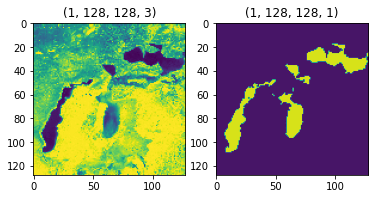

In [10]:
def plot_image_mask(image, mask):
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    fig, subplots = plt.subplots(nrows=1, ncols=2)
    subplots[0].set_title("{}".format(image.shape))
    subplots[0].imshow(image[0,...,0])
    subplots[1].set_title("{}".format(mask.shape))
    subplots[1].imshow(mask[0,...,0])

def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()

for image, mask in sem_seg_ds.take(1):
    plot_image_mask(image.numpy(), mask.numpy())